In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import RegularGridInterpolator



In [2]:
df = pd.read_csv('cmems_obs-ins_glo_phy-cur_my_drifter_PT1H_EWCT-NSCT_65.00W-55.00W_33.00N-43.00N_15.00m_2017-01-01-2018-01-01.csv')
df

,variable,platform_id,platform_type,time,longitude,latitude,depth,pressure,is_depth_from_producer,value,value_qc,institution,doi,product_doi
0,EWCT,1300872,DC,2017-05-08T05:00:00Z,-55.002747,33.81393,15.0,NaN,1,-0.2575,3,Meteo France Centre de Météorologie Marine,https://doi.org/10.17882/86236,https://doi.org/10.17882/86236
1,EWCT,1300872,DC,2017-05-08T06:00:00Z,-55.012115,33.82544,15.0,NaN,1,-0.2200,3,Meteo France Centre de Météorologie Marine,https://doi.org/10.17882/86236,https://doi.org/10.17882/86236
2,EWCT,1300872,DC,2017-05-08T07:00:00Z,-55.019836,33.83742,15.0,NaN,1,-0.1791,3,Meteo France Centre de Météorologie Marine,https://doi.org/10.17882/86236,https://doi.org/10.17882/86236
3,EWCT,1300872,DC,2017-05-08T08:00:00Z,-55.025330,33.84969,15.0,NaN,1,-0.1074,3,Meteo France Centre de Météorologie Marine,https://doi.org/10.17882/86236,https://doi.org/10.17882/86236
4,EWCT,1300872,DC,2017-05-08T09:00:00Z,-55.028046,33.86181,15.0,NaN,1,-0.0301,3,Meteo France Centre de Météorologie Marine,https://doi.org/10.17882/86236,https://doi.org/10.17882/86236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84313,NSCT,4401793,DC,2017-11-07T02:00:00Z,-55.033295,39.07078,15.0,NaN,1,0.6736,1,National Oceanic and Atmospheric Administratio...,https://doi.org/10.17882/86236,https://doi.org/10.17882/86236
84314,NSCT,4401793,DC,2017-11-07T03:00:00Z,-55.027405,39.09008,15.0,NaN,1,0.5725,1,National Oceanic and Atmospheric Administratio...,https://doi.org/10.17882/86236,https://doi.org/10.17882/86236
84315,NSCT,4401793,DC,2017-11-07T04:00:00Z,-55.022278,39.10789,15.0,NaN,1,0.4889,1,National Oceanic and Atmospheric Administratio...,https://doi.org/10.17882/86236,https://doi.org/10.17882/86236
84316,NSCT,4401793,DC,2017-11-07T05:00:00Z,-55.016205,39.12379,15.0,NaN,1,0.4938,1,National Oceanic and Atmospheric Administratio...,https://doi.org/10.17882/86236,https://doi.org/10.17882/86236


In [3]:
def split_trajectory(row, max_gap=pd.Timedelta('1h')):
    times = pd.to_datetime(row['time'])
    time_diff = times.to_series().diff().fillna(pd.Timedelta(0))
    
    split_idx = (time_diff > max_gap).to_numpy().nonzero()[0]
    split_idx = [0] + split_idx.tolist() + [len(times)]
    
    segments = []
    for i in range(len(split_idx) - 1):
        start, end = split_idx[i], split_idx[i+1]
        segment = {
            'drifter': row['drifter'],
            'time': times[start:end].to_list(),
            'latitude': row['latitude'][start:end],
            'longitude': row['longitude'][start:end],
        }
        if 'EWCT' in row:
            segment['EWCT'] = row['EWCT'][start:end]
        if 'NSCT' in row:
            segment['NSCT'] = row['NSCT'][start:end]
        segments.append(segment)
    
    return segments

def running_mean(x, window=24):
    return np.convolve(x, np.ones(window)/window, mode='valid')

def filter_row(row):
    lon = np.array(row['longitude'])
    lat = np.array(row['latitude'])
    ewct = np.array(row['EWCT'])
    nsct = np.array(row['NSCT'])

    lon_filt = running_mean(lon)
    lat_filt = running_mean(lat)
    ewct_filt = running_mean(ewct)
    nsct_filt = running_mean(nsct)
    
    time_num = np.array([t.timestamp() for t in row['time']])
    time_filt_num = running_mean(time_num)
    time_filt = pd.to_datetime(time_filt_num, unit='s')

    return pd.Series({
        'longitude_filt': lon_filt,
        'latitude_filt': lat_filt,
        'EWCT_filt': ewct_filt,
        'NSCT_filt': nsct_filt,
        'time_filt': time_filt
    })

def interp_single_var(df_drifters, da_map):

    def compute_row(row):
        lats = da_map.latitude.values 
        lons = da_map.longitude.values
        if np.max(lons < 0): 
            lons = lons % 360
        times = da_map.time.values

        ref_time = times[0]
        time_seconds = ((times - ref_time) / np.timedelta64(1, 's')).astype(float)

        u = da_map.values
        interp_func = RegularGridInterpolator((time_seconds,lats, lons), u, method='linear', bounds_error=False, fill_value=np.nan)

        interp_times = pd.to_datetime(row['time']).values
        interp_seconds = ((interp_times - ref_time) / np.timedelta64(1, 's')).astype(float)

        points = np.column_stack((interp_seconds, row['latitude'].astype(float), row['longitude'].astype(float) % 360))

        u_interp = interp_func(points)

        return u_interp
    
    interp = []
    for i in range(len(df_drifters)):
        interp.append(compute_row(df_drifters.iloc[i]))
    return interp
    

def interp_map_to_drifter(df_drifters, ds_map, map_name, interp_keys = ['u_geo', 'v_geo', 'u_total', 'v_total', 'u_ekman', 'v_ekman']):
    if 'lon' in ds_map.dims:
        ds = ds.rename({'lon': 'longitude'})
    if 'lat' in ds_map.dims:
        ds = ds.rename({'lon': 'latitude'})
    
    for key in interp_keys:
        df_drifters[key+'_'+map_name] = interp_single_var(df_drifters, ds_map[key])
    

In [4]:
ids = df['platform_id']
unique_ids = np.unique(ids)
n_drifters = len(unique_ids)

traj_lengths = []
data = []

for i, idx in enumerate(unique_ids):
    u = df[(df['variable'] == 'EWCT') & (df['platform_id'] == idx)]
    v = df[(df['variable'] == 'NSCT') & (df['platform_id'] == idx)]
    
    if not all(u['time'].values == v['time'].values):
        print(f"Warning: EWCT and NSCT time mismatch for drifter {idx}")
        continue
        
    qc_val = np.max(u['value_qc'])
    
    if qc_val == 1:

        entry = {
            'drifter': idx,
            'EWCT': u['value'].values,
            'NSCT': v['value'].values,
            'time': pd.to_datetime(u['time'].values),
            'longitude': u['longitude'].values,
            'latitude': u['latitude'].values,
            'value_qc': u['value_qc'].values,
            'depth': u['depth'].values
        }
        data.append(entry)
        traj_lengths.append(len(u))
df = pd.DataFrame(data)
all_segments = []
for _, row in df.iterrows():
    all_segments.extend(split_trajectory(row))

df = pd.DataFrame(all_segments)
fs = 1 / (60 ** 2)

lat0 = 38
R = 6378e3
om = 2 * np.pi / 86461
f = 2 * om * np.sin(np.deg2rad(lat0)) 
filt_freq = 0.8 * f

N = 10 * 24 # 10 days

def is_long_enough(row):
    return (len(row['time']) > N and
            len(row['longitude']) > N and
            len(row['latitude']) > N and
            len(row['EWCT']) > N and
            len(row['NSCT']) > N)

df = df[df.apply(is_long_enough, axis=1)].reset_index(drop=True)
filtered_cols = df.apply(filter_row, axis=1)
df = pd.concat([df, filtered_cols], axis=1)

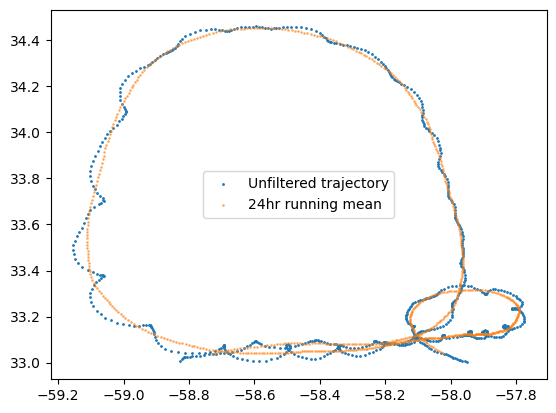

In [5]:
# check we filtered out the intertial oscillations...
idx = 20
plt.scatter(df.iloc[idx]['longitude'], df.iloc[idx]['latitude'], s = 1, label = 'Unfiltered trajectory')
plt.scatter(df.iloc[idx]['longitude_filt'], df.iloc[idx]['latitude_filt'], s = 1, alpha = 0.5, label = '24hr running mean')
plt.legend()

In [6]:
# interp maps 
ds_mdt = xr.open_dataset('/dat1/smart1n/ocean_data_challenges/2021a_SSH_mapping_OSE/data/dc_maps/OSE_ssh_mapping_convlstm_ssh-sst.nc')
mdt = ds_mdt['ssh'].isel(time=0, drop = True) - ds_mdt['sla'].isel(time=0, drop = True)

g = 9.81
lat0 = 38
R = 6378e3
om = 2 * np.pi / 86461
f = 2 * om * np.sin(np.deg2rad(lat0)) 
dx = R * (1 / 12) * np.cos(np.deg2rad(lat0)) * np.pi / 180
dy = R * (1 / 12) * np.pi / 180

ds_mdt['u_geo'] = (-(g / f) * ds_mdt['ssh'].diff('lat')) / (dy*0.1/(1/12))
ds_mdt['v_geo'] = ((g / f) * ds_mdt['ssh'].diff('lon')) / (dx*0.1/(1/12))
ds_mdt = ds_mdt.rename({'lon':'longitude','lat':'latitude'})
ds_mdt = ds_mdt.transpose('time', 'latitude','longitude')

ds_ekman = xr.open_dataset('/dat1/smart1n/glorys_pre_processed_fixed_noislands.nc').drop(['so','thetao','zos','uas','vas','tau_x','tau_y'])
ds_ekman = ds_ekman.sel(longitude=slice(-65,-55), latitude = slice(33,43), time = slice('20170101', '20171231'))
ds_ekman['u_ekman'] = ds_ekman['u_agos'] - ds_ekman['u_ageo_eddy']
ds_ekman['v_ekman'] = ds_ekman['v_agos'] - ds_ekman['v_ageo_eddy']
ds_ekman['longitude'] = ds_ekman['longitude'] % 360


interp_map_to_drifter(df, ds_mdt, map_name = 'ConvLSTM', interp_keys = ['u_geo','v_geo']) # convlstm
interp_map_to_drifter(df, ds_ekman, map_name = 'GLORYS', interp_keys = ['ugos_smoothed','vgos_smoothed', 'uo','vo']) # glorys

ds_map = xr.open_dataset('/dat1/smart1n/ocean_data_challenges/2021a_SSH_mapping_OSE/data/dc_maps/UNet_OSE_preds_single_sst_mask.nc')
ds_map['mdt'] = mdt.interp_like(ds_map)
ds_map['ssh'] = ds_map['sla'] + ds_map['mdt']
ds_map['u_geo'] = (-(g / f) * ds_map['ssh'].diff('lat')) / dy
ds_map['v_geo'] = ((g / f) * ds_map['ssh'].diff('lon')) / dx
ds_map = ds_map.rename({'lon':'longitude','lat':'latitude'})
ds_map = ds_map.transpose('time', 'latitude','longitude')
ds_map['u_ekman'] = ds_ekman['u_ekman'].interp_like(ds_map)
ds_map['v_ekman'] = ds_ekman['v_ekman'].interp_like(ds_map)
ds_map['u_total'] = ds_map['u_geo'] + ds_map['u_ekman'] + ds_map['u_ageo']
ds_map['v_total'] = ds_map['v_geo'] + ds_map['v_ekman'] + ds_map['v_ageo']

interp_map_to_drifter(df, ds_map, map_name = 'UNet')

ds_map = xr.open_dataset('/dat1/smart1n/ocean_data_challenges/2021a_SSH_mapping_OSE/data/dc_maps/GenDA_allsigma15km_mean_OSE_preds_single_sst_mask.nc')
ds_map['mdt'] = mdt.interp_like(ds_map)
ds_map['ssh'] = ds_map['sla'] + ds_map['mdt']
ds_map['u_geo'] = (-(g / f) * ds_map['ssh'].diff('lat')) / dy
ds_map['v_geo'] = ((g / f) * ds_map['ssh'].diff('lon')) / dx
ds_map = ds_map.rename({'lon':'longitude','lat':'latitude'})
ds_map = ds_map.transpose('time', 'latitude','longitude')
ds_map['u_ekman'] = ds_ekman['u_ekman'].interp_like(ds_map)
ds_map['v_ekman'] = ds_ekman['v_ekman'].interp_like(ds_map)
ds_map['u_total'] = ds_map['u_geo'] + ds_map['u_ekman'] + ds_map['u_ageo']
ds_map['v_total'] = ds_map['v_geo'] + ds_map['v_ekman'] + ds_map['v_ageo']

interp_map_to_drifter(df, ds_map, map_name = 'GenDA_ensemble')

ds_map = xr.open_dataset('/dat1/smart1n/ocean_data_challenges/2021a_SSH_mapping_OSE/data/dc_maps/GenDA_allsigma15km_member0_OSE_preds_single_sst_mask.nc')
ds_map['mdt'] = mdt.interp_like(ds_map)
ds_map['ssh'] = ds_map['sla'] + ds_map['mdt']
ds_map['u_geo'] = (-(g / f) * ds_map['ssh'].diff('lat')) / dy
ds_map['v_geo'] = ((g / f) * ds_map['ssh'].diff('lon')) / dx
ds_map = ds_map.rename({'lon':'longitude','lat':'latitude'})
ds_map = ds_map.transpose('time', 'latitude','longitude')
ds_map['u_ekman'] = ds_ekman['u_ekman'].interp_like(ds_map)
ds_map['v_ekman'] = ds_ekman['v_ekman'].interp_like(ds_map)
ds_map['u_total'] = ds_map['u_geo'] + ds_map['u_ekman'] + ds_map['u_ageo']
ds_map['v_total'] = ds_map['v_geo'] + ds_map['v_ekman'] + ds_map['v_ageo']

interp_map_to_drifter(df, ds_map, map_name = 'GenDA_member')





In [7]:
df.columns

Index(['drifter', 'time', 'latitude', 'longitude', 'EWCT', 'NSCT',
       'longitude_filt', 'latitude_filt', 'EWCT_filt', 'NSCT_filt',
       'time_filt', 'u_geo_ConvLSTM', 'v_geo_ConvLSTM', 'ugos_smoothed_GLORYS',
       'vgos_smoothed_GLORYS', 'uo_GLORYS', 'vo_GLORYS', 'u_geo_UNet',
       'v_geo_UNet', 'u_total_UNet', 'v_total_UNet', 'u_ekman_UNet',
       'v_ekman_UNet', 'u_geo_GenDA_ensemble', 'v_geo_GenDA_ensemble',
       'u_total_GenDA_ensemble', 'v_total_GenDA_ensemble',
       'u_ekman_GenDA_ensemble', 'v_ekman_GenDA_ensemble',
       'u_geo_GenDA_member', 'v_geo_GenDA_member', 'u_total_GenDA_member',
       'v_total_GenDA_member', 'u_ekman_GenDA_member', 'v_ekman_GenDA_member'],
      dtype='object')

In [43]:
def ORCAst_metrics(drifter_u, drifter_v, map_u, map_v):
    drifter_speed = np.sqrt(drifter_u ** 2 + drifter_v ** 2)
    map_speed = np.sqrt(map_u ** 2 + map_v ** 2)
    mask_slow = (drifter_speed > 0)
    drifter_u, drifter_v, map_u, map_v, drifter_speed, map_speed = drifter_u[mask_slow], drifter_v[mask_slow], map_u[mask_slow], map_v[mask_slow], drifter_speed[mask_slow], map_speed[mask_slow]
    
    # angle correct fraction:
    theta_criterion = 45
    theta = (180 / np.pi) * np.arccos(np.einsum('ij,ij->i', np.column_stack((map_u, map_v)), np.column_stack((drifter_u, drifter_v)))/(map_speed * drifter_speed))
    theta_correct = (theta <= theta_criterion)
    theta_correct = np.mean(theta_correct.astype(float))
    
    # magnitude correct fraction:
    mag_criterion = 0.025
    
    dM = np.abs(drifter_speed - map_speed)
    mag_correct = (dM <= mag_criterion)
    mag_correct = np.mean(mag_correct.astype(float))
    
    # mean error vector amplitude:
    
    dV = np.sqrt(np.sum(np.column_stack((map_u - drifter_u, map_v - drifter_v)) ** 2,axis = 1))
    
    u_rmse = np.sqrt(np.nanmean((drifter_u - map_u) ** 2))
    v_rmse = np.sqrt(np.nanmean((drifter_v - map_v) ** 2))
    u_pred_rms = np.sqrt(np.nanmean(map_u ** 2))
    v_pred_rms = np.sqrt(np.nanmean(map_v ** 2))
    
    
    return theta_correct, mag_correct, np.nanmean(dV), u_rmse, v_rmse, u_pred_rms, v_pred_rms
    
    
    

In [51]:
u_drifter = []
v_drifter = []
u_map = []
v_map = []
for idx in range(len(df)):
    u_drifter.append(df.iloc[idx]['EWCT'])
    v_drifter.append(df.iloc[idx]['NSCT'])
    u_map.append(df.iloc[idx]['u_total_GenDA_ensemble'])
    v_map.append(df.iloc[idx]['v_total_GenDA_ensemble'])
    
u_drifter = np.concatenate(u_drifter)
v_drifter = np.concatenate(v_drifter)
u_map = np.concatenate(u_map)
v_map = np.concatenate(v_map)

theta, mag, dV, u_rmse, v_rmse, u_pred_rms, v_pred_rms = ORCAst_metrics(u_drifter, v_drifter, u_map, v_map)

print('total')
# print(theta)
# print(mag)
print(dV)
print(u_rmse)
print(v_rmse)
# print(u_pred_rms)

u_drifter = []
v_drifter = []
u_map = []
v_map = []
for idx in range(len(df)):
    u_drifter.append(df.iloc[idx]['EWCT'])
    v_drifter.append(df.iloc[idx]['NSCT'])
    u_map.append(df.iloc[idx]['u_geo_GenDA_ensemble'] + df.iloc[idx]['u_ekman_GenDA_ensemble'])
    v_map.append(df.iloc[idx]['v_geo_GenDA_ensemble'] + df.iloc[idx]['v_ekman_GenDA_ensemble'])
    
u_drifter = np.concatenate(u_drifter)
v_drifter = np.concatenate(v_drifter)
u_map = np.concatenate(u_map)
v_map = np.concatenate(v_map)

theta, mag, dV, u_rmse, v_rmse, u_pred_rms, v_pred_rms = ORCAst_metrics(u_drifter, v_drifter, u_map, v_map)

print('geostrophic')
# print(theta)
# print(mag)
print(dV)
print(u_rmse)
print(v_rmse)
# print(u_pred_rms)
# print(v_pred_rms)



total
0.23654102406912444
0.20340103043628918
0.19484121184421307
geostrophic
0.23265024995527986
0.20059613707449384
0.19024327565423807


In [52]:
u_drifter = []
v_drifter = []
u_map = []
v_map = []
for idx in range(len(df)):
    u_drifter.append(df.iloc[idx]['EWCT'])
    v_drifter.append(df.iloc[idx]['NSCT'])
    u_map.append(df.iloc[idx]['uo_GLORYS'])
    v_map.append(df.iloc[idx]['vo_GLORYS'])
    
u_drifter = np.concatenate(u_drifter)
v_drifter = np.concatenate(v_drifter)
u_map = np.concatenate(u_map)
v_map = np.concatenate(v_map)

theta, mag, dV, u_rmse, v_rmse, u_pred_rms, v_pred_rms = ORCAst_metrics(u_drifter, v_drifter, u_map, v_map)

print('total')
# print(theta)
# print(mag)
print(dV)
print(u_rmse)
print(v_rmse)
# print(u_pred_rms)
# print(v_pred_rms)

u_drifter = []
v_drifter = []
u_map = []
v_map = []
for idx in range(len(df)):
    u_drifter.append(df.iloc[idx]['EWCT'])
    v_drifter.append(df.iloc[idx]['NSCT'])
    u_map.append(df.iloc[idx]['ugos_smoothed_GLORYS'] + df.iloc[idx]['u_ekman_GenDA_ensemble'])
    v_map.append(df.iloc[idx]['vgos_smoothed_GLORYS'] + df.iloc[idx]['v_ekman_GenDA_ensemble'])
    
u_drifter = np.concatenate(u_drifter)
v_drifter = np.concatenate(v_drifter)
u_map = np.concatenate(u_map)
v_map = np.concatenate(v_map)

theta, mag, dV, u_rmse, v_rmse, u_pred_rms, v_pred_rms = ORCAst_metrics(u_drifter, v_drifter, u_map, v_map)

print('geostrophic')
# print(theta)
# print(mag)
print(dV)
print(u_rmse)
print(v_rmse)
# print(u_pred_rms)
# print(v_pred_rms)



total
0.36363631145233
0.313612958138119
0.31510548247660886
geostrophic
0.3481099834486656
0.30231815430595105
0.30269491491032613


In [54]:
u_drifter = []
v_drifter = []
u_map = []
v_map = []
for idx in range(len(df)):
    u_drifter.append(df.iloc[idx]['EWCT'])
    v_drifter.append(df.iloc[idx]['NSCT'])
    u_map.append(df.iloc[idx]['u_total_GenDA_member'])
    v_map.append(df.iloc[idx]['v_total_GenDA_member'])
    
u_drifter = np.concatenate(u_drifter)
v_drifter = np.concatenate(v_drifter)
u_map = np.concatenate(u_map)
v_map = np.concatenate(v_map)

theta, mag, dV, u_rmse, v_rmse,_,_ = ORCAst_metrics(u_drifter, v_drifter, u_map, v_map)

print('total')
# print(theta)
# print(mag)
print(dV)
print(u_rmse)
print(v_rmse)

u_drifter = []
v_drifter = []
u_map = []
v_map = []
for idx in range(len(df)):
    u_drifter.append(df.iloc[idx]['EWCT'])
    v_drifter.append(df.iloc[idx]['NSCT'])
    u_map.append(df.iloc[idx]['u_geo_GenDA_member'] + df.iloc[idx]['u_ekman_GenDA_member'])
    v_map.append(df.iloc[idx]['v_geo_GenDA_member'] + df.iloc[idx]['v_ekman_GenDA_member'])
    
u_drifter = np.concatenate(u_drifter)
v_drifter = np.concatenate(v_drifter)
u_map = np.concatenate(u_map)
v_map = np.concatenate(v_map)

theta, mag, dV, u_rmse, v_rmse,_,_ = ORCAst_metrics(u_drifter, v_drifter, u_map, v_map)
print('geostrophic')
# print(theta)
# print(mag)
print(dV)
print(u_rmse)
print(v_rmse)



total
0.25178637607453724
0.22103585389919939
0.20179053659469623
geostrophic
0.24229867589097417
0.21003937139680098
0.1964148918591822


In [55]:
u_drifter = []
v_drifter = []
u_map = []
v_map = []
for idx in range(len(df)):
    u_drifter.append(df.iloc[idx]['EWCT'])
    v_drifter.append(df.iloc[idx]['NSCT'])
    u_map.append(df.iloc[idx]['u_geo_ConvLSTM'] + df.iloc[idx]['u_ekman_GenDA_ensemble'])
    v_map.append(df.iloc[idx]['v_geo_ConvLSTM'] + df.iloc[idx]['v_ekman_GenDA_ensemble'])
    
u_drifter = np.concatenate(u_drifter)
v_drifter = np.concatenate(v_drifter)
u_map = np.concatenate(u_map)
v_map = np.concatenate(v_map)

theta, mag, dV, u_rmse, v_rmse, u_pred_rms, v_pred_rms = ORCAst_metrics(u_drifter, v_drifter, u_map, v_map)

print('geostrophic')
# print(theta)
# print(mag)
print(dV)
print(u_rmse)
print(v_rmse)
# print(u_pred_rms)
# print(v_pred_rms)



geostrophic
0.23150978258450824
0.19807216097590538
0.18891105153364646


In [56]:
u_drifter = []
v_drifter = []
u_map = []
v_map = []
for idx in range(len(df)):
    u_drifter.append(df.iloc[idx]['EWCT'])
    v_drifter.append(df.iloc[idx]['NSCT'])
    u_map.append(df.iloc[idx]['u_total_UNet'])
    v_map.append(df.iloc[idx]['v_total_UNet'])
    
u_drifter = np.concatenate(u_drifter)
v_drifter = np.concatenate(v_drifter)
u_map = np.concatenate(u_map)
v_map = np.concatenate(v_map)

theta, mag, dV, u_rmse, v_rmse,_,_ = ORCAst_metrics(u_drifter, v_drifter, u_map, v_map)

print('total')
# print(theta)
# print(mag)
print(dV)
print(u_rmse)
print(v_rmse)

u_drifter = []
v_drifter = []
u_map = []
v_map = []
for idx in range(len(df)):
    u_drifter.append(df.iloc[idx]['EWCT'])
    v_drifter.append(df.iloc[idx]['NSCT'])
    u_map.append(df.iloc[idx]['u_geo_UNet'] + df.iloc[idx]['u_ekman_UNet'])
    v_map.append(df.iloc[idx]['v_geo_UNet'] + df.iloc[idx]['v_ekman_UNet'])
    
u_drifter = np.concatenate(u_drifter)
v_drifter = np.concatenate(v_drifter)
u_map = np.concatenate(u_map)
v_map = np.concatenate(v_map)

theta, mag, dV, u_rmse, v_rmse,_,_ = ORCAst_metrics(u_drifter, v_drifter, u_map, v_map)
print('geostrophic')
# print(theta)
# print(mag)
print(dV)
print(u_rmse)
print(v_rmse)



total
0.42322959614158656
0.4485096053460679
0.3547189457112504
geostrophic
0.3744314685013141
0.3741417051869989
0.3259392765916777


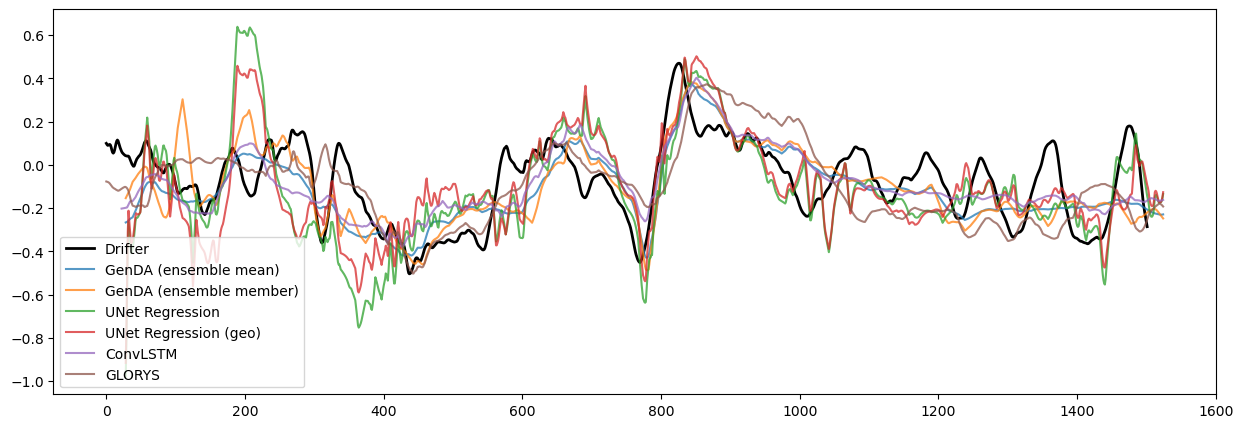

In [38]:
idx = np.random.randint(len(df))
plt.figure(figsize = (15,5))
plt.plot(df.iloc[idx]['NSCT_filt'], label = 'Drifter', color = 'black', linewidth = 2)
plt.plot(df.iloc[idx]['v_total_GenDA_ensemble'], label = 'GenDA (ensemble mean)', alpha = 0.75)
plt.plot(df.iloc[idx]['v_total_GenDA_member'], label = 'GenDA (ensemble member)', alpha = 0.75)
plt.plot(df.iloc[idx]['v_total_UNet'], label = 'UNet Regression', alpha = 0.75)
plt.plot(df.iloc[idx]['v_geo_UNet'], label = 'UNet Regression (geo)', alpha = 0.75)
plt.plot(df.iloc[idx]['v_geo_ConvLSTM'], label = 'ConvLSTM', alpha = 0.75)
plt.plot(df.iloc[idx]['vo_GLORYS'], label = 'GLORYS', alpha = 0.75)
# plt.plot(test.iloc[idx]['v_total_GenDA_ensemble'])
# plt.plot(test.iloc[idx]['v_ekman_GenDA_ensemble'])
# plt.plot(test.iloc[idx]['v_total_GenDA_ensemble'] - test.iloc[idx]['v_ekman_GenDA_ensemble'])
plt.legend()